# Siamese Neural Network - omniglot dataset

## Import Library

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, backend
import tensorflow_datasets as tfds

## Load the Omniglot dataset 

In [2]:
(ds_train, ds_test), ds_info = tfds.load('omniglot', split=['train','test'], with_info=True, shuffle_files=True)

In [3]:
input_shape = ds_info.features['image'].shape
print(input_shape)

(105, 105, 3)


In [4]:
print(list(ds_info.features.keys()))

['image', 'alphabet', 'alphabet_char_id', 'label']


In [5]:
ds_info.splits['train'].num_examples

19280

## Split the dataset to train and test

In [6]:
def normalize_img(left, right):
  """Normalizes images: `uint8` -> `float32`."""
  # left, right = case
  if left["alphabet"] == right["alphabet"]:
    flag = 0
  else:
    flag = 1
  return tf.cast(left["image"], tf.float32) / 255., tf.cast(right["image"], tf.float32) / 255., tf.cast(flag, tf.float32)

In [7]:
num_train = int(ds_info.splits['train'].num_examples / 2 * 0.8)
num_val = int(ds_info.splits['train'].num_examples / 2 * 0.2)
left_train = ds_train.take(num_train)
right_train = ds_train.skip(num_train).take(num_train)
left_val = ds_train.skip(num_train + num_train).take(num_val)
right_val = ds_train.skip(num_train + num_train + num_val).take(num_val)

ds_train = tf.data.Dataset.zip((left_train, right_train))
ds_val = tf.data.Dataset.zip((left_val, right_val))

train_x_left = []
train_x_right = []
train_y = []

for left, right in ds_train:
    left_x, right_x, flag = normalize_img(left, right)

    train_x_left.append(left_x)
    train_x_right.append(right_x)
    train_y.append(flag)

train_x_left = np.array(train_x_left)
train_x_right = np.array(train_x_right)
train_y = np.array(train_y)

In [8]:
val_x_left = []
val_x_right = []
val_y = []

for left, right in ds_train:
    left_x, right_x, flag = normalize_img(left, right)

    val_x_left.append(left_x)
    val_x_right.append(right_x)
    val_y.append(flag)

val_x_left = np.array(val_x_left)
val_x_right = np.array(val_x_right)
val_y = np.array(val_y)

In [9]:
num_test = int(ds_info.splits['test'].num_examples / 2)
left_test = ds_test.take(num_test)
right_test = ds_test.skip(num_test).take(num_test)
ds_test = tf.data.Dataset.zip((left_test, right_test))

test_x_left = []
test_x_right = []
test_y = []

for left, right in ds_test:
    left_x, right_x, flag = normalize_img(left, right)

    test_x_left.append(left_x)
    test_x_right.append(right_x)
    test_y.append(flag)

test_x_left = np.array(test_x_left)
test_x_right = np.array(test_x_right)
test_y = np.array(test_y)

In [10]:
print(train_x_left.shape, train_x_right.shape, train_y.shape)
print(test_x_left.shape, test_x_right.shape, test_y.shape)

(7712, 105, 105, 3) (7712, 105, 105, 3) (7712,)
(6590, 105, 105, 3) (6590, 105, 105, 3) (6590,)


In [11]:
# def normalize_img(case):
#   """Normalizes images: `uint8` -> `float32`."""
#   return tf.cast(case["image"], tf.float32) / 255., case["alphabet"]


In [12]:
# ds_train = ds_train.map(
#   normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(int(ds_info.splits['train'].num_examples/2))
# ds_train = ds_train.batch(128)
# ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
# ds_test = ds_test.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.batch(128)
# ds_test = ds_test.cache()
# ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
def triplet_loss(y_true, y_pred, margin = 0.4):
    """Implementation of the triplet loss function

    Arguments:
        y_true : true labels, required when you define a loss in Keras, 
                not applied in this function.

        y_pred (list): python list containing three objects:
            anchor : the encodings for the anchor data
            positive : the encodings for the positive data (similar to anchor)
            negative : the encodings for the negative data (different from anchor)
        
        margin (float, optional): m > 0 determines how far the embeddings of 
                    a negative data should be pushed apart. Defaults to 0.4.

    Returns:
        loss (float): real number, value of the loss
    """

    anchor = y_pred[0]
    positive = y_pred[1]
    negative = y_pred[2]

    # squared distance between the anchor and the positive
    pos_dist = tf.math.reduce_sum(tf.math.square(anchor - positive), axis=1)

    # squared distance between the anchor and the negative
    neg_dist = tf.math.reduce_sum(tf.math.square(anchor - negative), axis=1)

    # compute loss
    basic_loss = margin + pos_dist - neg_dist
    loss = tf.math.maximum(basic_loss,0.0)
    loss = tf.math.reduce_mean(loss)
    return loss


def contrastive_loss(y_true, y_pred, margin = 0.4):
    """Implementation of the triplet loss function

    Inspired by https://stackoverflow.com/questions/38260113/implementing-contrastive-loss-and-triplet-loss-in-tensorflow

    Args:
        y_true (int): true label, positive pair (same class) -> 0, 
                    negative pair (different class) -> 1
        
        y_pred (list): python list containing two objects in a pair of tensors:
            left : the encodings for one image data in a pair
            right : the encodings for the other image data in a pair
        
        margin (float, optional): m > 0 determines how far the embeddings of 
                    a negative pair should be pushed apart. Defaults to 0.4.

    Returns:
        loss (float): real number, value of the loss
    """

    left = y_pred[0]
    right = y_pred[1]

    # squared distance between the left image and the right image
    dist = tf.math.reduce_sum(tf.math.square(left - right))

    loss_positive = dist
    loss_negative = tf.math.square(tf.maximum(0., margin - tf.math.sqrt(dist)))
    
    loss = y_true * loss_negative + (1 - y_true) * loss_positive
    loss = 0.5 * tf.math.reduce_mean(loss)

    return loss


In [15]:
def siamese_networks(input_shape):

    left_input = Input(shape=input_shape, name="left_img")
    x = layers.Conv2D(filters=64, kernel_size=(10,10), activation='relu')(left_input)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=128, kernel_size=(7,7), activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=128, kernel_size=(4,4), activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=256, kernel_size=(4,4), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='sigmoid')(x)

    right_input = Input(shape=input_shape, name="right_img")
    y = layers.Conv2D(filters=64, kernel_size=(10,10), activation='relu')(right_input)
    y = layers.MaxPool2D(pool_size=(2,2))(y)
    y = layers.Conv2D(filters=128, kernel_size=(7,7), activation='relu')(y)
    y = layers.MaxPool2D(pool_size=(2,2))(y)
    y = layers.Conv2D(filters=128, kernel_size=(4,4), activation='relu')(y)
    y = layers.MaxPool2D(pool_size=(2,2))(y)
    y = layers.Conv2D(filters=256, kernel_size=(4,4), activation='relu')(y)
    y = layers.Flatten()(y)
    y = layers.Dense(4096, activation='sigmoid')(y)

    L1_layer = layers.Lambda(lambda tensors:backend.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([x, y])

    prediction = layers.Dense(1,activation='sigmoid')(L1_distance)

    model = keras.Model(inputs=[left_input, right_input], outputs=prediction, name="siamese_networks")

    return model




In [16]:
!pip install pydot

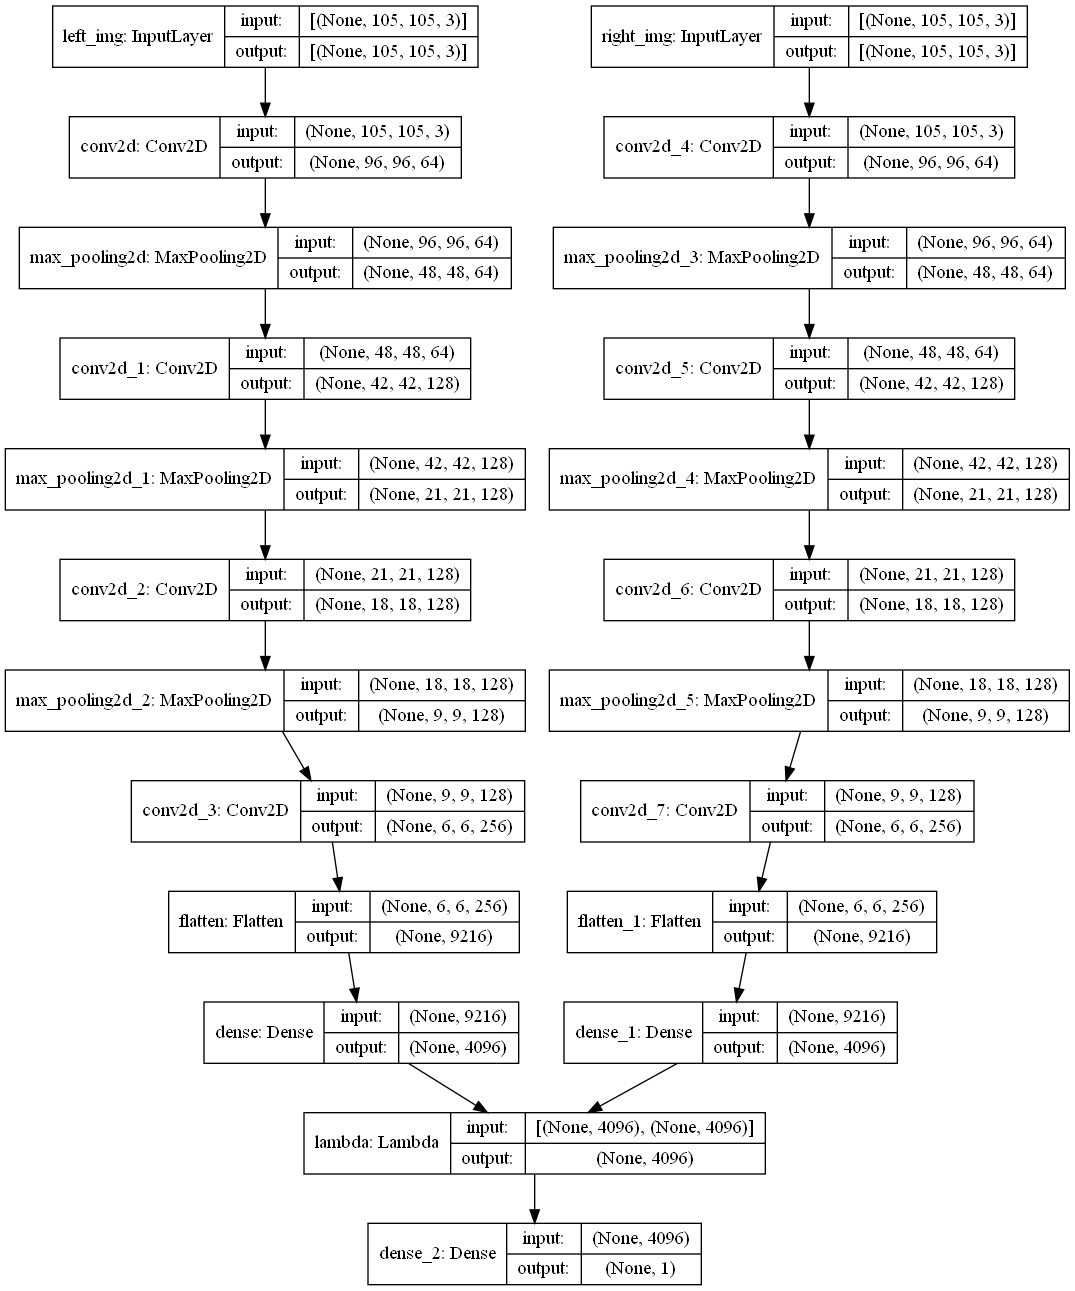

In [17]:
model = siamese_networks(input_shape)
keras.utils.plot_model(model, "siamese_networks.png", show_shapes=True)

In [18]:
model.summary()

Model: "siamese_networks"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_img (InputLayer)           [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
right_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 64)   19264       left_img[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 96, 96, 64)   19264       right_img[0][0]                  
___________________________________________________________________________________

In [19]:
# A2_i = np.random.randint(0, 256, size=(1, 105, 105, 3)).astype("float32")
# A2_j = np.random.randint(0, 256, size=(1, 105, 105, 3)).astype("float32")

# model([A2_i, A2_j]).numpy()

In [20]:
model.compile(
    loss=contrastive_loss,
    optimizer=keras.optimizers.SGD(),
    metrics=["accuracy"],
)


In [21]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.5,
                                                patience=5,
                                                verbose=0,
                                                mode='auto',
                                                min_delta=0.0001,
                                                cooldown=0,
                                                min_lr=0)

history = model.fit(
    x=[train_x_left, train_x_right],
    y=train_y,
    epochs=50,
    batch_size=128,
    validation_data=([val_x_left, val_x_right], val_y),
    callbacks=[early_stopping, lr_reducer],
)

Epoch 1/50
61/61 [==============================] - 23s 193ms/step - loss: 0.0757 - accuracy: 0.2295 - val_loss: 0.0754 - val_accuracy: 0.1206
Epoch 2/50
61/61 [==============================] - 8s 133ms/step - loss: 0.0752 - accuracy: 0.1180 - val_loss: 0.0750 - val_accuracy: 0.0808
Epoch 3/50
61/61 [==============================] - 8s 136ms/step - loss: 0.0747 - accuracy: 0.0698 - val_loss: 0.0743 - val_accuracy: 0.0982
Epoch 4/50
61/61 [==============================] - 8s 138ms/step - loss: 0.0738 - accuracy: 0.1096 - val_loss: 0.0733 - val_accuracy: 0.1634
Epoch 5/50
61/61 [==============================] - 8s 137ms/step - loss: 0.0727 - accuracy: 0.1512 - val_loss: 0.0721 - val_accuracy: 0.1531
Epoch 6/50
61/61 [==============================] - 8s 134ms/step - loss: 0.0715 - accuracy: 0.1834 - val_loss: 0.0701 - val_accuracy: 0.2601
Epoch 7/50
61/61 [==============================] - 8s 134ms/step - loss: 0.0702 - accuracy: 0.2574 - val_loss: 0.0681 - val_accuracy: 0.2047
Epoch

In [22]:
score = model.evaluate(x=[test_x_left,test_x_right],y=test_y, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

206/206 [==============================] - 3s 15ms/step - loss: 0.0220 - accuracy: 0.4768
Test loss: 0.02197411097586155
Test accuracy: 0.47678300738334656


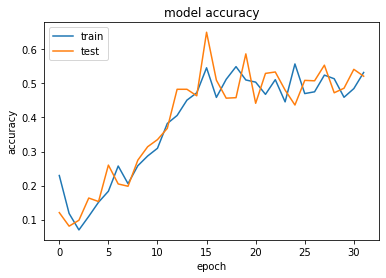

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

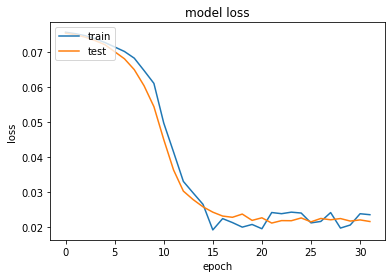

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()